In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys
import astropy.units as units
import pandas as pd
import lightkurve as lk
import importlib


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]

In [3]:
lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,17):
    lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))


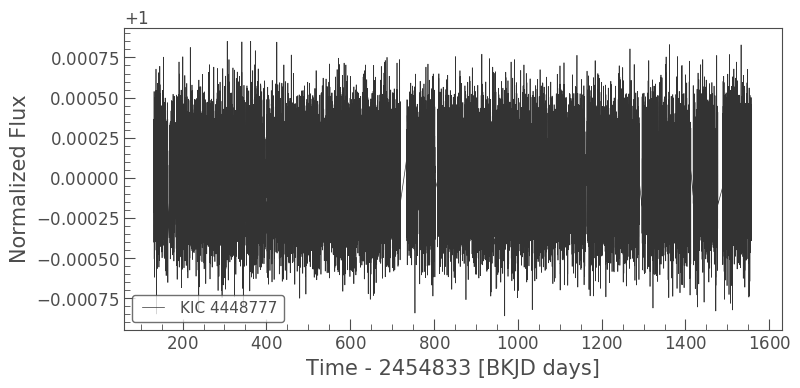

In [4]:
lc = lc.remove_outliers(4)
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0).flatten()

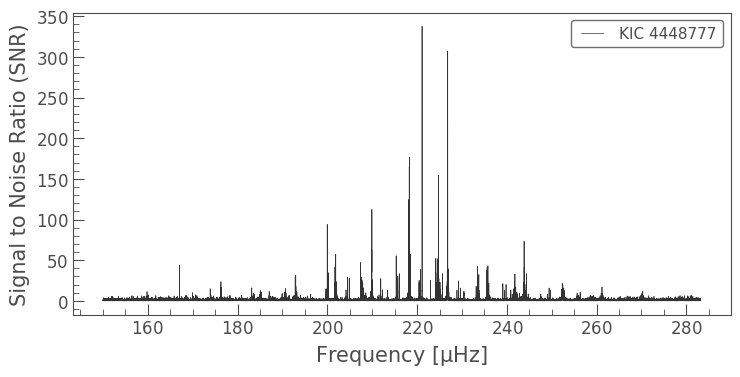

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

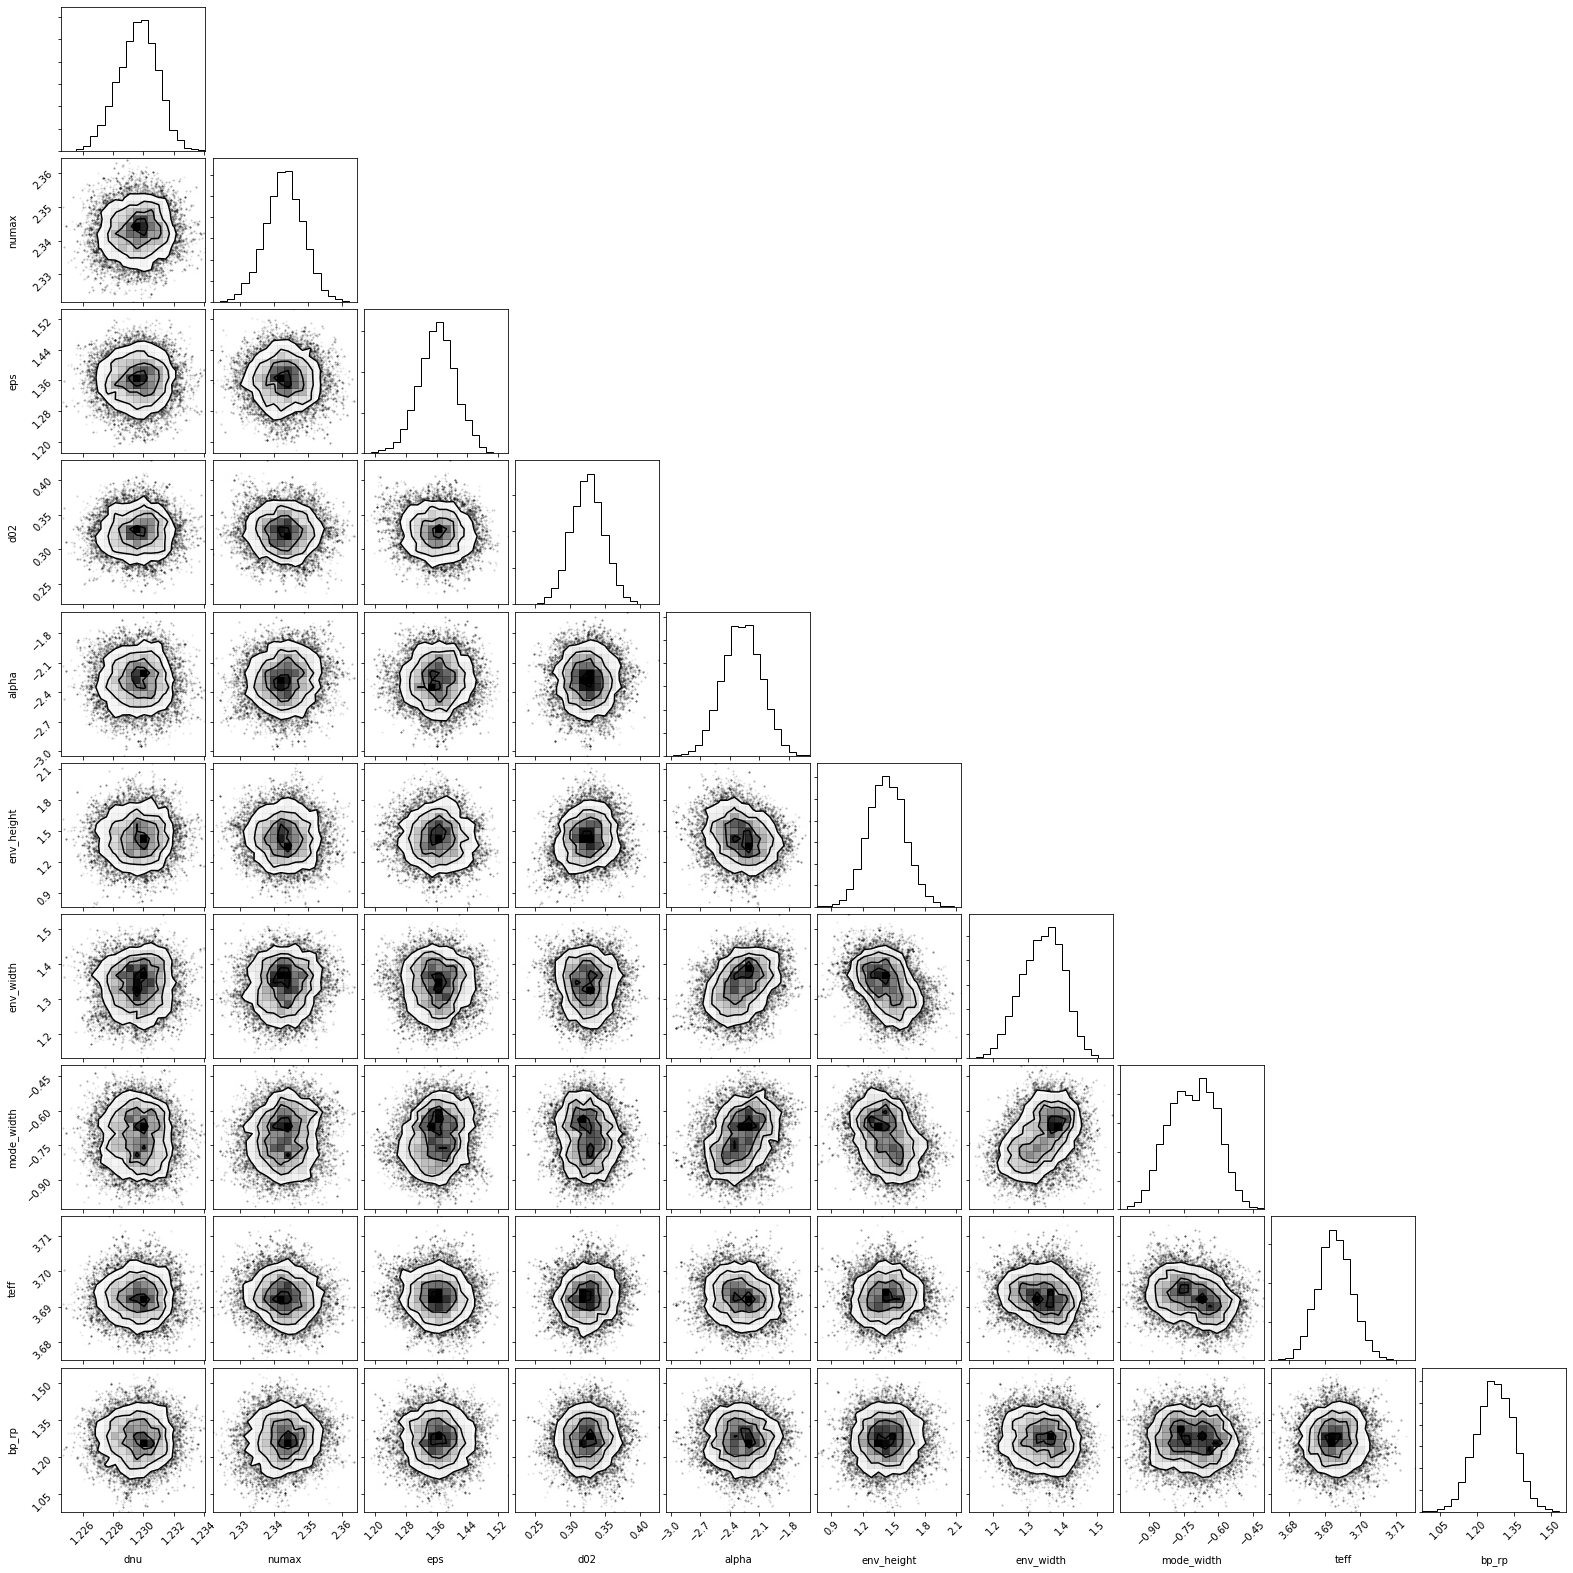

In [8]:
import corner
corner.corner(ep.samples, labels=ep.cols);

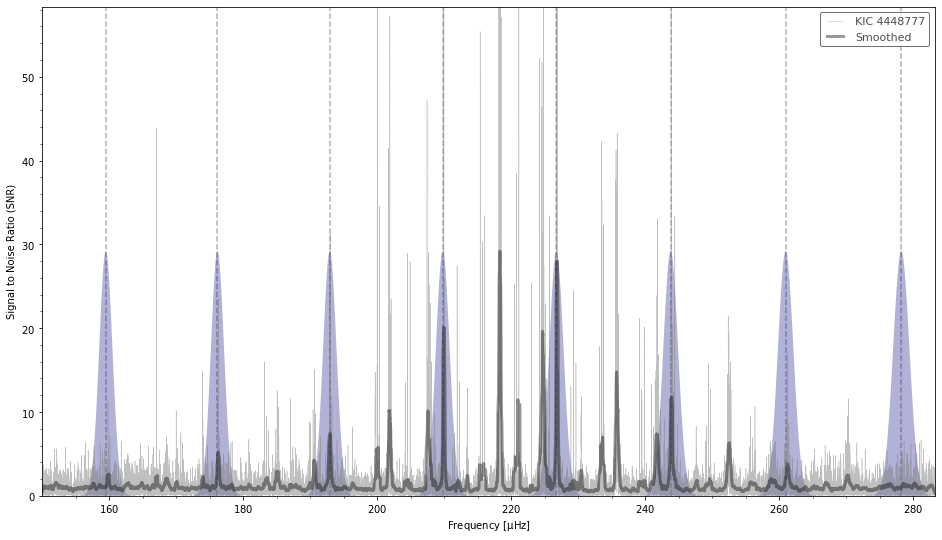

In [9]:
ep.plot(pg)

In [10]:
importlib.reload(pb.asy_peakbag)
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=4, norders=5,
                                    store_chains=True)

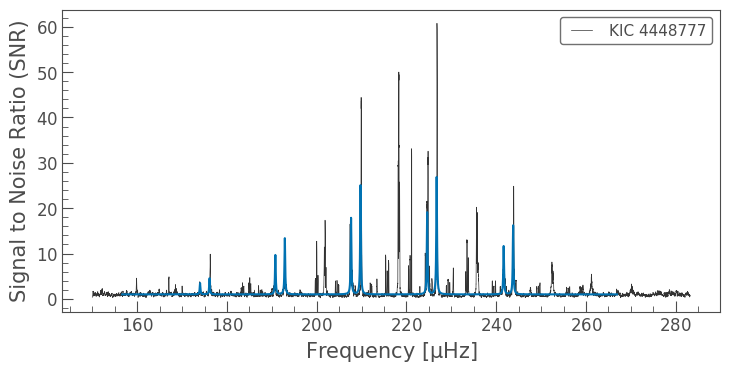

In [11]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.start))

In [12]:
asy_result = asy.run(burnin=1000, niter=1000)

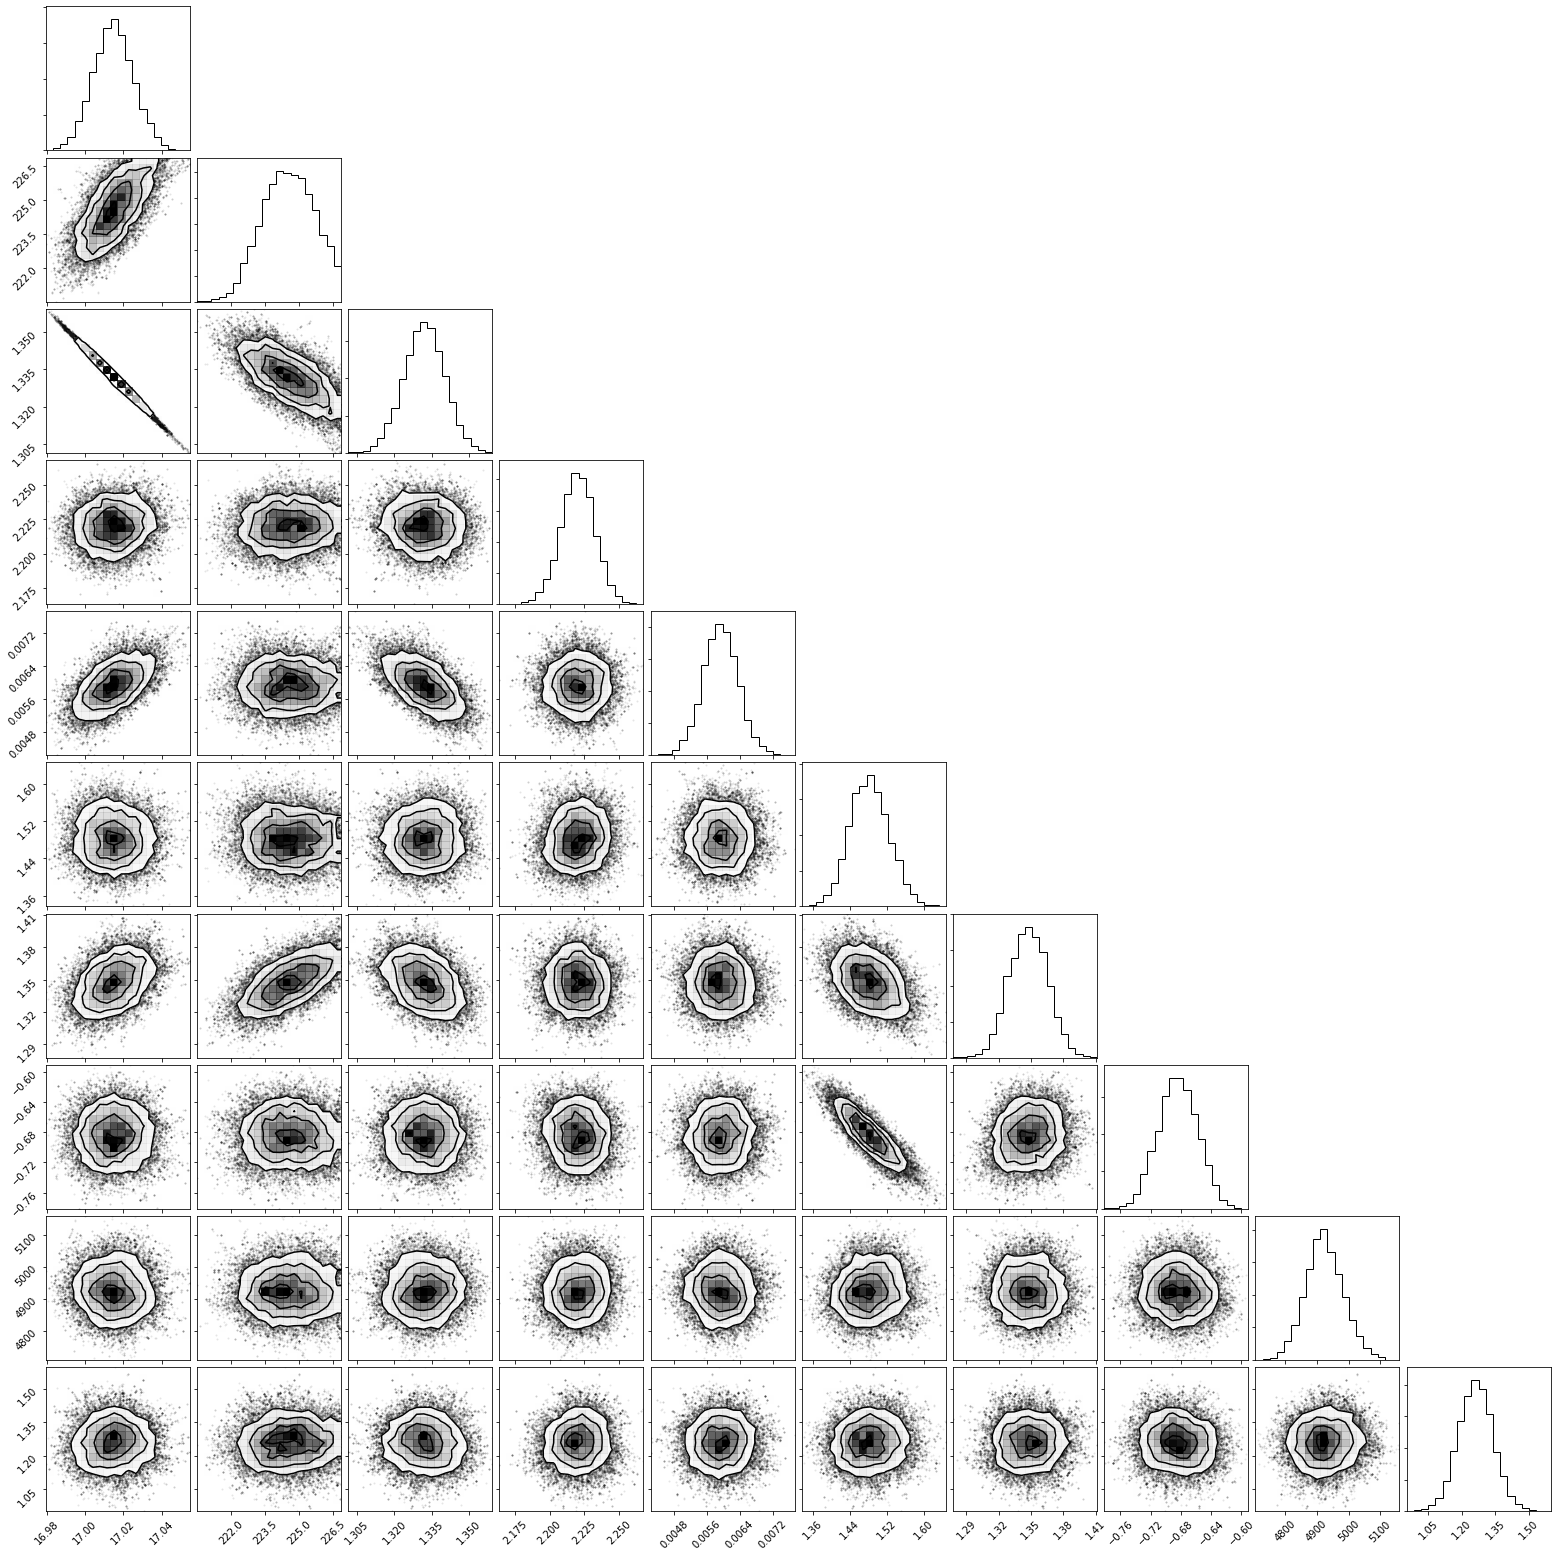

In [13]:
corner.corner(asy.flatchain);

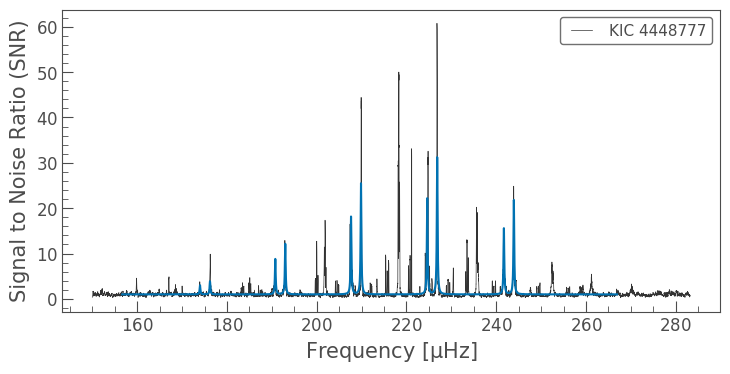

In [14]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.flatchain.mean(axis=0)))

In [15]:
asy_result['summary']

,dnu,numax,eps,d02,alpha,env_height,env_width,mode_width,teff,bp_rp
16th,17.004373,223.367627,1.323749,2.208052,0.005513,1.440582,1.329670,-0.710692,4866.399055,1.183643
2nd,16.994077,222.334384,1.315250,2.194856,0.005065,1.401912,1.313574,-0.735455,4809.761452,1.106286
50th,17.014777,224.542706,1.331981,2.220396,0.005931,1.481592,1.347628,-0.684235,4922.561875,1.261860
84th,17.025428,225.742314,1.340134,2.232517,0.006353,1.524929,1.365244,-0.657228,4985.300392,1.337688
97th,17.036245,226.595045,1.348253,2.244182,0.006818,1.569114,1.382959,-0.632282,5049.687747,1.418318
MAD,0.010487,1.216910,0.008195,0.012140,0.000430,0.042901,0.018095,0.026367,58.593668,0.077239
mean,17.014862,224.533040,1.331933,2.220269,0.005933,1.482654,1.347668,-0.683925,4925.133437,1.261365
mle,17.011638,224.029881,1.334376,2.216177,0.005965,1.466138,1.345086,-0.674800,4895.973751,1.256094
skew,0.076015,-0.130037,-0.069560,-0.085521,0.032566,0.140464,0.031316,-0.009675,0.160196,0.015107
std,0.010558,1.120682,0.008224,0.012326,0.000431,0.041928,0.017579,0.026192,59.560675,0.077863


In [16]:
import importlib
import pbjam

In [17]:
importlib.reload(pbjam)
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

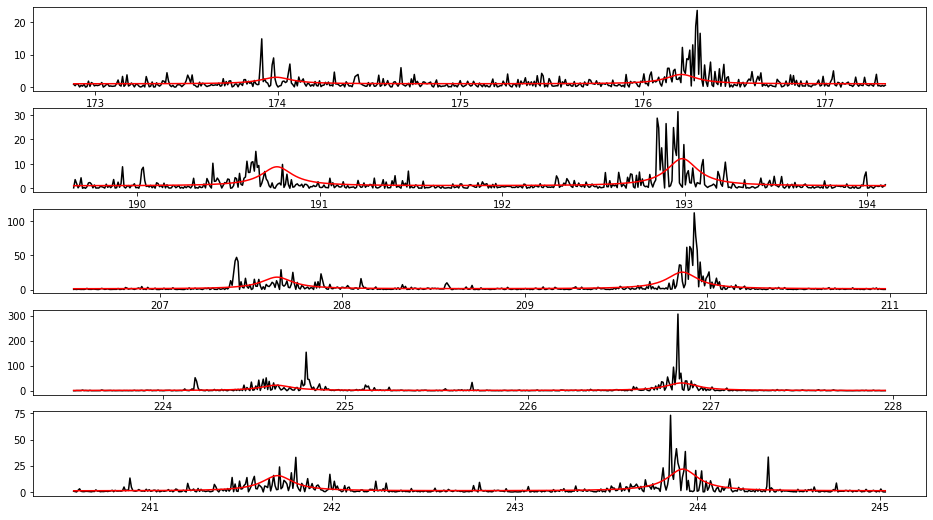

In [18]:
pbag.plot_start_model()

In [19]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:27<00:00, 291.66draws/s]


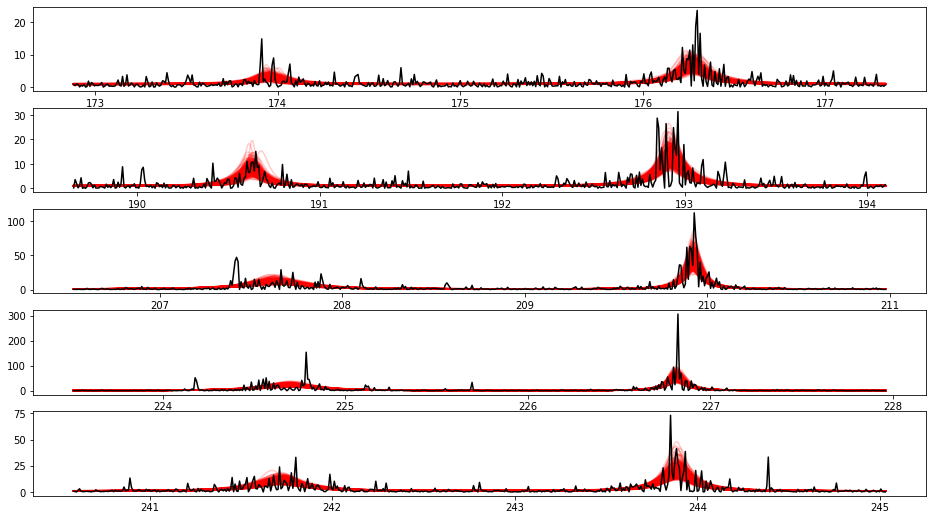

In [20]:
pbag.plot_fit(thin=1)

In [22]:
import pymc3 as pm
pm.summary(pbag.samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
l0__0,176.269913,0.017236,0.000245,176.236165,176.303982,4855.384664,0.999189
l0__1,192.924219,0.015723,0.000250,192.895287,192.955503,4790.563743,0.999608
l0__2,209.924268,0.009074,0.000136,209.907164,209.942289,4686.955451,0.999446
l0__3,226.814501,0.008976,0.000125,226.797154,226.832371,5106.216103,0.999189
l0__4,243.889475,0.016417,0.000280,243.856594,243.919411,3380.573403,0.999591
l2__0,173.954368,0.029205,0.000631,173.899946,174.009214,1931.011965,0.999128
l2__1,190.628050,0.017463,0.000329,190.591844,190.661553,3329.842967,0.999696
l2__2,207.640689,0.024594,0.000477,207.590585,207.686167,2924.172220,0.999999
l2__3,224.689701,0.019871,0.000290,224.647669,224.727196,4981.151876,0.999616
l2__4,241.715337,0.022053,0.000403,241.670175,241.754596,3734.826624,0.999199
